In [33]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import copy
import random
import multiprocessing as mp
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [34]:
!export CUDA_LAUNCH_BLOCKING=1


In [35]:
# Enable CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [36]:
# torch.cuda.set_device(1)  # Use GPU 1

# # Verify that the correct GPU is being used
# if torch.cuda.is_available():
#     current_device = torch.cuda.current_device()
#     print(f"Using GPU: {torch.cuda.get_device_name(current_device)}")
#     print(f"Device ID: {current_device}")

In [37]:
# Load node features
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0)  # Substrates CSV file
p_df = pd.read_csv('//data/servilla/DT_HGNN/Model/Nodes/p_emb_full_237197.csv', index_col=0)  # Combined proteins CSV file


In [38]:
# # Load node features
# s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/No_text_nodes/s_emb_no_text_183.csv', index_col=0)  # Substrates CSV file
# proteins_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/No_text_nodes/p_emb_no_text_237197.csv', index_col=0)  # Combined proteins CSV file


In [39]:
# # Load node features
# s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0)  # Substrates CSV file
# proteins_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/Zero_Features_Nodes/p_emb_filtered _0.csv', index_col=0)  # Combined proteins CSV file


In [40]:
s_df

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ChEBI ID,,,,,,,,,,,,,,,,,,,,,
CHEBI:30616,0.455800,0.268283,-0.306537,0.050826,-0.386505,-0.471963,-0.836031,-0.192729,-1.156560,-0.272351,...,0.480035,-0.456548,-0.099031,-0.462904,-0.471903,-0.142393,-0.475653,-0.365997,-0.848439,-0.244717
CHEBI:64837,0.615461,0.182076,-0.157183,-0.101461,-0.146697,-0.613957,-0.450166,-0.183678,-0.624151,-0.271550,...,0.107556,-0.293493,-0.117009,0.133840,-0.734478,-0.017846,-0.497699,0.045008,-0.386243,-0.474938
CHEBI:58245,0.506397,0.400621,0.064001,-0.252644,-0.300555,-0.395209,-0.638782,-0.311317,-1.088331,-0.142135,...,0.350439,-0.128131,-0.003493,-0.408475,-0.426437,-0.205415,-0.840490,-0.568522,-0.887295,-0.210402
CHEBI:57673,0.438195,0.195334,0.072717,-0.337968,-0.261332,-0.498841,-0.686211,-0.416058,-0.848771,-0.195883,...,0.379729,-0.210616,0.100455,-0.483885,-0.470335,-0.155050,-0.884785,-0.499907,-0.748851,-0.243686
CHEBI:58115,0.263242,0.269032,0.145805,-0.515321,-0.187021,-0.480719,-0.610310,-0.469400,-0.936680,-0.147377,...,0.176869,-0.017013,0.130641,-0.251108,-0.505997,0.049098,-0.935488,-0.402900,-1.060279,-0.297512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEBI:17821,0.023680,0.181743,-0.468458,-0.544133,-0.462411,-0.216898,-0.611499,-0.537903,-1.444201,-0.396138,...,0.192647,0.243999,-0.094861,-0.463224,-0.749601,-0.850797,0.202593,-0.268341,-0.374329,-0.572429
CHEBI:16708,0.096989,0.625387,-0.322925,-0.704778,-0.569291,-0.014360,-0.661434,-0.700171,-1.437007,0.076964,...,0.350745,0.274081,-0.197719,-0.049403,-0.751242,-0.279356,0.015822,-0.010360,0.142680,-0.341658
CHEBI:16040,0.621236,0.530406,-0.460275,-0.801638,-0.524102,-0.129895,-0.411074,-0.879548,-1.166363,-0.003238,...,0.412461,0.175881,-0.243160,-0.114933,-0.512422,-0.668245,0.257403,-0.211986,0.005222,-0.508171


In [41]:
p_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
Uniprot ID,,,,,,,,,,,,,,,,,,,,,
A0A061ACU2,-0.006915,0.017029,-0.012460,0.009969,-0.034116,-0.067283,0.063458,0.032882,-0.022449,0.050131,...,-0.055087,-0.014889,-0.111876,-0.341646,-0.072502,-0.323306,-0.056634,0.290476,-0.039389,0.168516
A0A061AE05,0.035674,-0.022189,-0.009367,-0.004829,-0.069653,-0.014517,0.044575,-0.132423,-0.021363,-0.007532,...,-0.163456,-0.056955,-0.099271,-0.458213,-0.038014,-0.183186,-0.225026,0.419967,-0.160937,0.212690
A0A061I403,0.053080,-0.078657,0.038157,-0.005594,-0.030804,-0.007899,-0.074586,-0.035587,-0.045537,0.027765,...,-0.089691,0.042491,-0.139474,-0.520852,0.032338,-0.228753,-0.163234,0.391762,-0.193620,0.197258
A0A072ULZ1,0.061750,-0.051334,-0.038662,0.045027,-0.004024,-0.051204,0.090917,-0.132791,-0.079478,0.076762,...,-0.156411,0.033456,-0.092049,-0.477360,0.118776,-0.227023,-0.209066,0.333932,-0.138006,0.150505
A0A072VDF2,-0.039073,-0.042116,0.003819,0.026522,0.000374,-0.040989,0.012172,-0.054791,0.003940,0.048461,...,-0.137038,0.013142,-0.135132,-0.456653,0.051990,-0.205040,-0.102661,0.373307,-0.127597,0.118297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9ZU96,-0.039020,-0.071629,-0.052520,0.034033,-0.092409,-0.087255,0.029642,0.003676,-0.055408,0.074894,...,-0.011945,0.051887,-0.091516,-0.475149,0.043887,-0.123123,0.027734,0.276535,-0.114138,0.146494
Q9ZUH0,-0.045847,-0.016646,0.028537,0.077879,-0.114865,0.026522,-0.045645,0.133281,-0.005342,0.116256,...,0.038638,0.073979,-0.087714,-0.357490,0.032010,-0.088160,-0.005223,0.335018,-0.271940,0.066000
Q9ZUU2,0.056914,-0.073989,-0.014398,0.084379,0.026393,-0.043069,0.006505,-0.078882,0.044475,0.130091,...,0.009835,0.040818,-0.086419,-0.396256,0.071960,-0.125251,0.028300,0.308530,-0.165650,0.108122


In [42]:
# Load edges
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/distributed_combined_tp_s_edges_13340.csv')
ppi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ppi_edges_full.csv')
ssi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ssi_edges_full.csv')

In [43]:
# Inspect and clean the data
def inspect_and_clean(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns: {non_numeric_columns}")
    if len(non_numeric_columns) > 0:
        df[non_numeric_columns] = df[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    return df

In [44]:
s_df = inspect_and_clean(s_df)
p_df = inspect_and_clean(p_df)

Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [45]:
# Convert features to numpy arrays
s_features = s_df.values
p_features = p_df.values

In [46]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (183, 1536), no KD (212, 768)
print(f"p_features shape: {p_features.shape}")  # Expected (some number, 2048), no KD (571609, 1280)

s_features shape: (183, 1536)
p_features shape: (237197, 2048)


In [47]:
# # Use GPU 1
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Device: {device}")

In [48]:
# Normalize features (normalizes columns to have mean 0 and variance 1)
s_features = (s_features - np.mean(s_features, axis=0)) / np.std(s_features, axis=0)
p_features = (p_features - np.mean(p_features, axis=0)) / np.std(p_features, axis=0)

In [49]:
# Define the transformation layers, changes the number of features 1536 -> 2048
# for substrates and 2048 -> 2048 for proteins. The transform_p layer is useful 
# for transforming the feature representation within the same dimensional space,
#  y = Wx + b.

device = torch.device('cpu')  # Temporarily switch to CPU


transform_s = Linear(1536, 2048).to(device) # Change depending on the number of features
transform_p = Linear(2048, 2048).to(device)

In [50]:
# Apply transformations in batches, this can be useful when dealing with large 
# datasets that may not fit into memory or GPU all at once. 
def transform_in_batches(features, transform_layer, batch_size=10000):
    num_samples = features.shape[0]
    print(f"Number of samples: {num_samples}")
    transformed_features = []
    for i in range(0, num_samples, batch_size):
        batch = features[i:i + batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float).to(device)
        transformed_batch = transform_layer(batch_tensor)
        transformed_features.append(transformed_batch.detach().cpu().numpy())  # Use detach() before numpy()
    return np.vstack(transformed_features) # Stack arrays in sequence vertically (row wise)


In [51]:
s_features_transformed = transform_in_batches(s_features, transform_s)
p_features_transformed = transform_in_batches(p_features, transform_p)

Number of samples: 183
Number of samples: 237197


In [52]:
# Convert back to tensors
s_features_tensor = torch.tensor(s_features_transformed, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_features_transformed, dtype=torch.float).to(device)


In [53]:
# Combine features, vertically stacks features (dim=0) to create a single tensor
all_features = torch.cat([p_features_tensor, s_features_tensor], dim=0)


In [54]:
protein_ids = set(p_df.index)
substrate_ids = set(s_df.index)

In [55]:
def split_data(df, train_size=0.8, val_size=0.1, test_size=0.1):
    # Split into train and temp (80% train, 20% temp)
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # Calculate the size for validation and test splits
    val_test_ratio = val_size / (val_size + test_size)  # 50% of temp goes to validation and 50% to test

    # Split temp into validation and test (10% each)
    val_df, test_df = train_test_split(temp_df, train_size=val_test_ratio, random_state=42)
    
    return train_df, val_df, test_df

In [56]:
# Split data for each edge type
ppi_train_df, ppi_val_df, ppi_test_df = split_data(ppi_df)
ssi_train_df, ssi_val_df, ssi_test_df = split_data(ssi_df)
tp_s_train_df, tp_s_val_df, tp_s_test_df = split_data(tp_s_df)

In [57]:
tp_s_train_df

,source,target,label
22326,B5Z8R5,CHEBI:17757,0
24868,Q2J6N1,CHEBI:16389,0
15236,P24981,CHEBI:132124,0
20396,P30750,CHEBI:57926,0
20230,C3P1E2,CHEBI:41509,0
...,...,...,...
21575,Q8FAV1,CHEBI:15378,0
5390,P0A437,CHEBI:16813,1
860,Q1I7Z8,CHEBI:132124,1
15795,A1XGU4,CHEBI:132124,0


In [58]:
# Create separate mappings
protein_mapping = {node_id: i for i, node_id in enumerate(p_df.index)}
substrate_mapping = {node_id: i for i, node_id in enumerate(s_df.index)}

# Helper function to apply the correct mapping
def apply_correct_mapping(df, source_mapping, target_mapping):
    df['source'] = df['source'].map(source_mapping)
    df['target'] = df['target'].map(target_mapping)
    df.dropna(inplace=True)
    return df

# Apply the correct mappings
tp_s_train_df = apply_correct_mapping(tp_s_train_df, protein_mapping, substrate_mapping)
tp_s_val_df = apply_correct_mapping(tp_s_val_df, protein_mapping, substrate_mapping)
tp_s_test_df = apply_correct_mapping(tp_s_test_df, protein_mapping, substrate_mapping)

ppi_train_df = apply_correct_mapping(ppi_train_df, protein_mapping, protein_mapping)
ppi_val_df = apply_correct_mapping(ppi_val_df, protein_mapping, protein_mapping)
ppi_test_df = apply_correct_mapping(ppi_test_df, protein_mapping, protein_mapping)

ssi_train_df = apply_correct_mapping(ssi_train_df, substrate_mapping, substrate_mapping)
ssi_val_df = apply_correct_mapping(ssi_val_df, substrate_mapping, substrate_mapping)
ssi_test_df = apply_correct_mapping(ssi_test_df, substrate_mapping, substrate_mapping)


In [59]:
tp_s_full_df = apply_correct_mapping(tp_s_df, protein_mapping, substrate_mapping)
ppi_full_df = apply_correct_mapping(ppi_df, protein_mapping, protein_mapping)
ssi_full_df = apply_correct_mapping(ssi_df, substrate_mapping, substrate_mapping)

In [60]:
print(tp_s_full_df)
print(ppi_full_df)
print(ssi_full_df)

       source  target  label
0      110150       0      1
1      113110       0      1
2       94944      63      1
3       86624      63      1
4      132714       0      1
...       ...     ...    ...
26675  118949      18      0
26676   87873       0      0
26677   88009      19      0
26678   97381      63      0
26679  148748      63      0

[26680 rows x 3 columns]
          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71     

In [27]:
# Create edge index tensors
train_edges_tp_s = torch.tensor(tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_tp_s = torch.tensor(tp_s_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_tp_s = torch.tensor(tp_s_test_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ppi = torch.tensor(ppi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ppi = torch.tensor(ppi_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_ppi = torch.tensor(ppi_test_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ssi = torch.tensor(ssi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ssi = torch.tensor(ssi_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_ssi = torch.tensor(ssi_test_df[['source', 'target']].values.T, dtype=torch.long)

# Convert the labels to tensors
train_labels_tp_s = torch.tensor(tp_s_train_df['label'].values, dtype=torch.float)
val_labels_tp_s = torch.tensor(tp_s_val_df['label'].values, dtype=torch.float)
test_labels_tp_s = torch.tensor(tp_s_test_df['label'].values, dtype=torch.float)

train_labels_ppi = torch.tensor(ppi_train_df['label'].values, dtype=torch.float)
val_labels_ppi = torch.tensor(ppi_val_df['label'].values, dtype=torch.float)
test_labels_ppi = torch.tensor(ppi_test_df['label'].values, dtype=torch.float)

train_labels_ssi = torch.tensor(ssi_train_df['label'].values, dtype=torch.float)
val_labels_ssi = torch.tensor(ssi_val_df['label'].values, dtype=torch.float)
test_labels_ssi = torch.tensor(ssi_test_df['label'].values, dtype=torch.float)


In [67]:
positive_tp_s_full_df = tp_s_full_df[tp_s_full_df['label'] == 1]


positive_ppi_full_df = ppi_full_df[ppi_full_df['label'] == 1]


positive_ssi_full_df = ssi_full_df[ssi_full_df['label'] == 1]



In [71]:
full_positive_edges_tp_s = torch.tensor(positive_tp_s_full_df[['source', 'target']].values, dtype=torch.long).t().contiguous()
full_positive_edges_ppi = torch.tensor(positive_ppi_full_df[['source', 'target']].values, dtype=torch.long).t().contiguous()
full_positive_edges_ssi = torch.tensor(positive_ssi_full_df[['source', 'target']].values, dtype=torch.long).t().contiguous()

In [28]:
positive_tp_s_train_df = tp_s_train_df[tp_s_train_df['label'] == 1]

train_edges_tp_s_positive = torch.tensor(positive_tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ppi_train_df = ppi_train_df[ppi_train_df['label'] == 1]

train_edges_ppi_positive = torch.tensor(positive_ppi_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ssi_train_df = ssi_train_df[ssi_train_df['label'] == 1]

train_edges_ssi_positive = torch.tensor(positive_ssi_train_df[['source', 'target']].values.T, dtype=torch.long)


In [73]:
print(full_positive_edges_tp_s.shape)

torch.Size([2, 13340])


In [29]:
# Define the percentage of edges to remove
ppi_removal_percentage = 1.0  # Remove 20% of PPI edges
ssi_removal_percentage = 1.0  # Remove 20% of SSI edges
tp_s_removal_percentage = 1.0  # Remove 20% of tp_s edges


# Function to remove a percentage of edges
def remove_edges(edges, removal_percentage):
    num_edges = edges.size(1)
    num_to_remove = int(removal_percentage * num_edges)
    indices_to_keep = torch.randperm(num_edges)[:-num_to_remove]  # Randomly select edges to keep
    return edges[:, indices_to_keep]

# Remove a percentage of PPI edges
train_edges_ppi_positive_reduced = remove_edges(train_edges_ppi_positive, ppi_removal_percentage)

# Remove a percentage of SSI edges
train_edges_ssi_positive_reduced = remove_edges(train_edges_ssi_positive, ssi_removal_percentage)

# Remove a percentage of tp_s edges
train_edges_tp_s_positive_reduced = remove_edges(train_edges_tp_s_positive, tp_s_removal_percentage)


In [74]:
data = HeteroData()

# Assign node features
data['protein'].x = p_features_tensor
data['substrate'].x = s_features_tensor

# # Assign training edges
data['protein', 'interacts_with', 'substrate'].edge_index = full_positive_edges_tp_s
data['protein', 'interacts_with', 'protein'].edge_index = full_positive_edges_ppi
data['substrate', 'interacts_with', 'substrate'].edge_index = full_positive_edges_ssi

# # Assign training edges
# data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s
# data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi_positive
# data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi_positive

# # Assign training edges
# data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s_positive_reduced
# data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi_positive_reduced
# data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi_positive_reduced

# # Assign training edges
# data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s
# data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi
# data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi


In [75]:
import pickle
# Save the dictionary as a .pkl file
with open('/data/servilla/DT_HGNN/Model/pkl_Files/x_dict.pkl', 'wb') as f:
    pickle.dump(data.x_dict, f)

with open('/data/servilla/DT_HGNN/Model/pkl_Files/edge_index_dict.pkl', 'wb') as f:
    pickle.dump(data.edge_index_dict, f)

In [ ]:
print(f"p_features tensor shape: {p_features_tensor.shape}")
print(f"s_features tensor shape: {s_features_tensor.shape}")
print(f"full edges tp_s shape: {full_edges_tp_s.shape}")
print(f"positive train edges ppi shape: {full_edges_ppi.shape}")
print(f"positive train edges ssi shape: {train_edges_ssi_positive.shape}")

In [31]:
print(f"p_features tensor shape: {p_features_tensor.shape}")
print(f"s_features tensor shape: {s_features_tensor.shape}")
print(f"positive train edges tp_s shape: {train_edges_tp_s_positive.shape}")
print(f"positive train edges ppi shape: {train_edges_ppi_positive.shape}")
print(f"positive train edges ssi shape: {train_edges_ssi_positive.shape}")

p_features tensor shape: torch.Size([237197, 2048])
s_features tensor shape: torch.Size([183, 2048])
positive train edges tp_s shape: torch.Size([2, 10651])
positive train edges ppi shape: torch.Size([2, 5331163])
positive train edges ssi shape: torch.Size([2, 1718])


In [32]:
print(f"p_features tensor shape: {p_features_tensor.shape}")
print(f"s_features tensor shape: {s_features_tensor.shape}")
print(f"positive train edges tp_s reduced shape: {train_edges_tp_s_positive_reduced.shape}")
print(f"positive train edges ppi reduced shape: {train_edges_ppi_positive_reduced.shape}")
print(f"positive train edges ssi reduced shape: {train_edges_ssi_positive_reduced.shape}")

p_features tensor shape: torch.Size([237197, 2048])
s_features tensor shape: torch.Size([183, 2048])
positive train edges tp_s reduced shape: torch.Size([2, 0])
positive train edges ppi reduced shape: torch.Size([2, 0])
positive train edges ssi reduced shape: torch.Size([2, 0])


In [ ]:
# Initialize the model
class GCNLinkPredictor(nn.Module):
    def __init__(self, protein_dim, substrate_dim, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.protein_conv1 = GCNConv(protein_dim, hidden_channels)
        self.substrate_conv1 = GCNConv(substrate_dim, hidden_channels)
        self.protein_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.substrate_conv2 = GCNConv(hidden_channels, hidden_channels)

        # GCN layer for tp_s interactions
        self.tp_s_conv = GCNConv(hidden_channels, hidden_channels)

        self.link_predictor = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    # Copy the encode function from the working model
    def encode(self, x_dict, edge_index_dict):
        # Use ppi edges to update protein embeddings
        z_protein = self.protein_conv1(x_dict['protein'], edge_index_dict[('protein', 'interacts_with', 'protein')])
        z_protein = self.protein_conv2(z_protein, edge_index_dict[('protein', 'interacts_with', 'protein')])

        # Use ssi edges to update substrate embeddings
        z_substrate = self.substrate_conv1(x_dict['substrate'], edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        z_substrate = self.substrate_conv2(z_substrate, edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        
        # Use tp_s edges to update embeddings
        edge_indices = edge_index_dict[('protein', 'interacts_with', 'substrate')]
        protein_indices = edge_indices[0]
        substrate_indices = edge_indices[1]

        z_protein_tp_s = self.protein_conv1(x_dict['protein'], torch.stack([protein_indices, protein_indices], dim=0))
        z_substrate_tp_s = self.substrate_conv1(x_dict['substrate'], torch.stack([substrate_indices, substrate_indices], dim=0))

        z_protein += z_protein_tp_s
        z_substrate += z_substrate_tp_s

        return z_protein, z_substrate

    def forward(self, x_dict, edge_index_dict, edges):
        z_protein, z_substrate = self.encode(x_dict, edge_index_dict)
        z_combined = torch.cat([z_protein[edges[0]], z_substrate[edges[1]]], dim=-1)
        return self.link_predictor(z_combined).squeeze()

# Initialize the model (ADJUST DIMENSIONS HERE!!!!!!!)
model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)


# Assuming `data` contains x_dict and edge_index_dict
x_dict = data.x_dict
edge_index_dict = data.edge_index_dict

def train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with all edges
    z_protein, z_substrate = model.encode(x_dict, edge_index_dict)
    
    # For loss, only use tp_s edges
    z_combined = torch.cat([z_protein[train_edges_tp_s[0]], z_substrate[train_edges_tp_s[1]]], dim=-1)
    out = model.link_predictor(z_combined).squeeze()
    
    # Calculate loss only for tp_s edges
    loss = criterion(out, train_labels_tp_s)
    loss.backward()
    optimizer.step()

    return loss.item(), out.detach()


def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict, val_edges_tp_s)
        loss = criterion(out, val_labels_tp_s)
    return loss.item(), out

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict, test_edges_tp_s)
        loss = criterion(out, test_labels_tp_s)
    return loss.item(), out

# Calculate additional metrics
def calculate_metrics(labels, preds):
    preds = torch.sigmoid(preds).cpu().numpy()
    preds_binary = (preds > 0.5).astype(int)
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds_binary)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)
    auc = roc_auc_score(labels, preds)

    return accuracy, precision, recall, f1, auc

# Modify the training loop to include metric calculation and visualization
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 800
for epoch in range(epochs):
    # Training step
    train_loss, train_preds = train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s)
    # Validation step
    val_loss, val_preds = validate()

    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate validation metrics
    accuracy, precision, recall, f1, auc = calculate_metrics(val_labels_tp_s, val_preds)
    val_accuracies.append(accuracy)

    # Print metrics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, AUC: {auc:.4f}, LR: {scheduler.get_last_lr()[0]}")

    # Step the LR scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), '/data/servilla/DT_HGNN/data/Models_saves/best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load the best model
model.load_state_dict(torch.load('/data/servilla/DT_HGNN/data/Models_saves/best_model.pth'))

# Testing
test_loss, test_preds = test()
test_accuracy, test_precision, test_recall, test_f1, test_auc = calculate_metrics(test_labels_tp_s, test_preds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

# Step 4: Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

# Step 5: Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


### START AUPRC TESTING HERE

In [33]:
# Initialize the model
class GCNLinkPredictor(nn.Module):
    def __init__(self, protein_dim, substrate_dim, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.protein_conv1 = GCNConv(protein_dim, hidden_channels)
        self.substrate_conv1 = GCNConv(substrate_dim, hidden_channels)
        self.protein_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.substrate_conv2 = GCNConv(hidden_channels, hidden_channels)

        # GCN layer for tp_s interactions
        self.tp_s_conv = GCNConv(hidden_channels, hidden_channels)

        self.link_predictor = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    # Copy the encode function from the working model
    def encode(self, x_dict, edge_index_dict):
        # Use ppi edges to update protein embeddings
        z_protein = self.protein_conv1(x_dict['protein'], edge_index_dict[('protein', 'interacts_with', 'protein')])
        z_protein = self.protein_conv2(z_protein, edge_index_dict[('protein', 'interacts_with', 'protein')])

        # Use ssi edges to update substrate embeddings
        z_substrate = self.substrate_conv1(x_dict['substrate'], edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        z_substrate = self.substrate_conv2(z_substrate, edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        
        # Use tp_s edges to update embeddings
        edge_indices = edge_index_dict[('protein', 'interacts_with', 'substrate')]
        protein_indices = edge_indices[0]
        substrate_indices = edge_indices[1]

        z_protein_tp_s = self.protein_conv1(x_dict['protein'], torch.stack([protein_indices, protein_indices], dim=0))
        z_substrate_tp_s = self.substrate_conv1(x_dict['substrate'], torch.stack([substrate_indices, substrate_indices], dim=0))

        z_protein += z_protein_tp_s
        z_substrate += z_substrate_tp_s

        return z_protein, z_substrate

    def forward(self, x_dict, edge_index_dict, edges):
        z_protein, z_substrate = self.encode(x_dict, edge_index_dict)
        z_combined = torch.cat([z_protein[edges[0]], z_substrate[edges[1]]], dim=-1)
        return self.link_predictor(z_combined).squeeze()

# Initialize the model (ADJUST DIMENSIONS HERE!!!!!!!)
model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)


# Assuming `data` contains x_dict and edge_index_dict
x_dict = data.x_dict
edge_index_dict = data.edge_index_dict

In [37]:
# Function to load the model and run AUPRC and AUC testing
def run_auprc_auc_testing(model_path, x_dict, edge_index_dict, test_edges_tp_s, protein_df, device):
    # Load the best model
    model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)  # Adjust model params
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set model to evaluation mode
    
    # New AUPRC and AUC testing per substrate
    true_positive_edges = test_edges_tp_s  # Make sure this variable holds valid test edges

    # Evaluate AUPRC and AUC for each unique substrate
    results = evaluate_all_substrates(model, x_dict, edge_index_dict, true_positive_edges, protein_df, device)

    # Print average AUPRC and AUC across all substrates
    avg_auprc = np.mean([res['auprc'] for res in results.values()])
    avg_auc = np.mean([res['auc'] for res in results.values()])
    print(f"Average AUPRC across all substrates: {avg_auprc:.4f}")
    print(f"Average AUC across all substrates: {avg_auc:.4f}")

    return results, avg_auprc, avg_auc

# AUPRC and AUC evaluation functions
def evaluate_all_substrates(model, x_dict, edge_index_dict, true_positive_edges, protein_df, device):
    unique_substrates = true_positive_edges[1].unique().tolist()
    
    substrate_metrics = {}
    
    for substrate in unique_substrates:
        auprc, auc_score, precision, recall, fpr, tpr = evaluate_substrate_auprc_auc(
            model, x_dict, edge_index_dict, substrate, true_positive_edges, protein_df, device
        )
        substrate_metrics[substrate] = {'auprc': auprc, 'auc': auc_score}
        print(f"Substrate {substrate} AUPRC: {auprc:.4f}, AUC: {auc_score:.4f}")
    
    return substrate_metrics

# Function to calculate both AUPRC and AUC for a given substrate
def evaluate_substrate_auprc_auc(model, x_dict, edge_index_dict, substrate_index, true_positive_edges, protein_df, device, seed=42):
    np.random.seed(seed)  # Set seed for reproducibility

    # Get all associated transporter proteins (positive edges)
    mask = true_positive_edges[1] == substrate_index  # Mask for the current substrate
    pos_proteins = true_positive_edges[0][mask].tolist()  # Get the corresponding transporter proteins
    print(f"Proteins: {pos_proteins}")

    # Generate 100 negative edges (proteins not linked to this substrate)
    all_proteins = list(range(len(protein_df)))  # Assuming protein_df index corresponds to protein indices
    neg_proteins = np.random.choice(list(set(all_proteins) - set(pos_proteins)), size=100, replace=False)

    # Create edges: positive and negative
    test_edges = torch.cat([torch.tensor(pos_proteins).unsqueeze(0),
                            torch.full((1, len(pos_proteins)), substrate_index)], dim=0)
    neg_edges = torch.cat([torch.tensor(neg_proteins).unsqueeze(0),
                           torch.full((1, len(neg_proteins)), substrate_index)], dim=0)

    # Combine positive and negative edges
    all_edges = torch.cat([test_edges, neg_edges], dim=1)
    
    # Create labels: 1 for positive edges, 0 for negative edges
    labels = torch.cat([torch.ones(len(pos_proteins)), torch.zeros(100)])

    # Forward pass through the model
    with torch.no_grad():
        preds = model(x_dict, edge_index_dict, all_edges)

    # Calculate precision-recall curve and AUPRC
    precision, recall, _ = precision_recall_curve(labels.cpu().numpy(), torch.sigmoid(preds).cpu().numpy())
    auprc_value = auc(recall, precision)  # Calculate AUPRC

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels.cpu().numpy(), torch.sigmoid(preds).cpu().numpy())
    auc_value = auc(fpr, tpr)  # Calculate AUC

    return auprc_value, auc_value, precision, recall, fpr, tpr

# Run the AUPRC and AUC testing
model_path = '/data/servilla/DT_HGNN/data/Models_saves/best_model.pth'  # Path to your saved model
device = torch.device('cpu')  # Temporarily switch to CPU

# Assuming `data` contains x_dict and edge_index_dict
x_dict = data.x_dict
edge_index_dict = data.edge_index_dict

# Assuming test_edges_tp_s and p_df are already defined

# Call the function to run AUPRC and AUC testing
results, avg_auprc, avg_auc = run_auprc_auc_testing(model_path, x_dict, edge_index_dict, test_edges_tp_s, p_df, device)


Proteins: [105249, 59389, 112387, 199741, 132320, 146918, 148764, 138323, 141230, 111150, 121088, 191202, 86195, 115928, 90981, 108390, 145404, 88355, 2215, 190388, 125705, 19538, 117685, 89632, 74872, 117455, 73297, 110731, 25756, 228325, 53606, 106600, 91721, 126844, 195962, 159392, 29391, 2165, 200018, 107318, 115102, 152978, 30451, 82414, 121598, 110148, 119954, 118698, 86810, 114307, 119897, 80221, 120677, 17189, 115807, 74227, 81260, 172327, 200796, 94291, 8783, 83600, 135537, 80308, 97975, 114723, 103695, 85503, 86196, 177650, 89347, 128642, 149161, 136723, 163521, 143781, 121216, 70558, 153858, 166922, 127456, 128780, 110003, 208202, 122063, 183926, 124231, 77951, 150231, 103342, 110124, 162976, 149705, 138722, 133317, 85998, 152599, 125605, 142105, 78421, 148340, 113987, 97034, 152639, 104981, 41788, 108015, 137132, 155371, 132073, 113348, 65236, 12592, 135352, 118408, 89392, 82796, 84238, 110509, 148015, 103604, 106306, 132955, 74218, 114007, 118004, 134684, 115392, 184810, 1

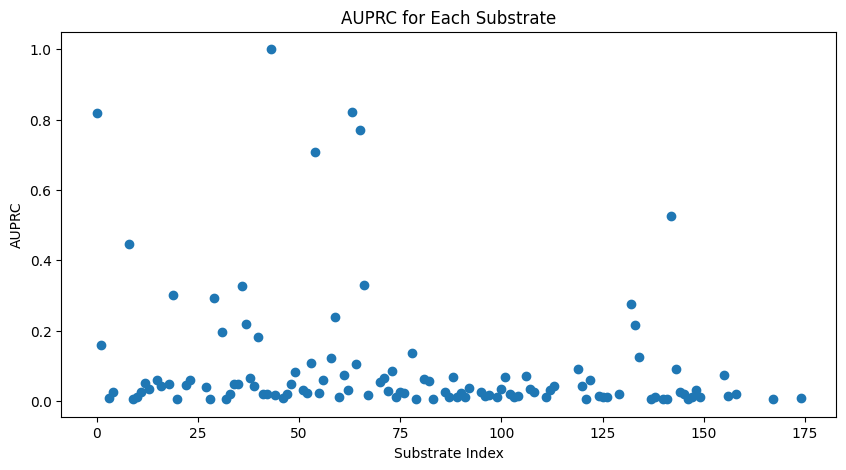

In [35]:
# Optional: Visualize AUPRC for each substrate (example)
plt.figure(figsize=(10, 5))

# Create lists for substrates and AUPRC values
substrates = list(auprcs.keys())
auprc_values = list(auprcs.values())

# Plot the AUPRC values
plt.scatter(substrates, auprc_values)

# Add labels and title
plt.xlabel('Substrate Index')
plt.ylabel('AUPRC')
plt.title('AUPRC for Each Substrate')

# Show the plot
plt.show()


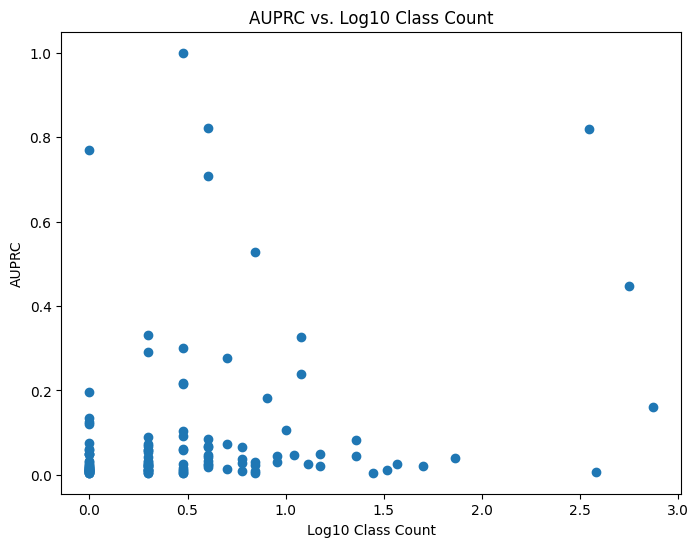

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import Counter

# Assuming you have the following data:
# - auprcs: a dictionary containing AUPRC values for each substrate
# - class_counts: a dictionary containing the count of occurrences for each substrate
# Get the substrate indices (second row of the edges tensor)
substrates_in_edges = test_edges_tp_s[1].tolist()  # Convert tensor to a list

# Count occurrences of each substrate
class_counts = Counter(substrates_in_edges)
# Convert AUPRC values and class counts to lists
auprc_values = list(auprcs.values())
class_count_values = list(class_counts.values())

# Compute the log10 of class counts for the x-axis
log_class_count = np.log10(class_count_values)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(log_class_count, auprc_values)

# Add labels and title
plt.xlabel('Log10 Class Count')
plt.ylabel('AUPRC')
plt.title('AUPRC vs. Log10 Class Count')

# Show the plot
plt.show()


In [ ]:
tp_s_test_df

In [ ]:
positive_tp_s_test_df = tp_s_test_df[tp_s_test_df['label'] == 1]
positive_tp_s_test_df

In [40]:
target_set = set(positive_tp_s_test_df['target'])


In [ ]:
grouped_targets = positive_tp_s_test_df.groupby(['target'])
len(grouped_targets)

In [ ]:
for target_value in target_set:
    substrate_group = grouped_targets.get_group(target_value)
    print(f"{substrate_group}")
    print()